In [1]:
!git clone https://github.com/karencfisher/GAN-experiments.git
%cd GAN-experiments

Cloning into 'GAN-experiments'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (13/13), done.
remote: Total 16 (delta 5), reused 13 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (16/16), 1.45 MiB | 22.18 MiB/s, done.
Resolving deltas: 100% (5/5), done.
/content/GAN-experiments


In [2]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torchvision import datasets
from torchvision import transforms
from tqdm import tqdm

from utils import view_samples
from training import train_discriminator, train_generator, make_samples

In [3]:
# For face generation, switch to CelebA dataset
# Download CelebA from http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html or use torchvision if available
# Example: from torchvision.datasets import CelebA
# celeba = CelebA(root='data/', split='train', download=True, transform=transform)

# For now, keeping CIFAR as example, but adapt for faces
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

cifar_train = datasets.CIFAR10(root='data/', download=True, transform=transform)

batch_size = 128
num_workers = 4

# build DataLoaders for CIFAR10 dataset
train_loader = torch.utils.data.DataLoader(dataset=cifar_train,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=num_workers)

100%|██████████| 170M/170M [00:05<00:00, 30.1MB/s]
/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


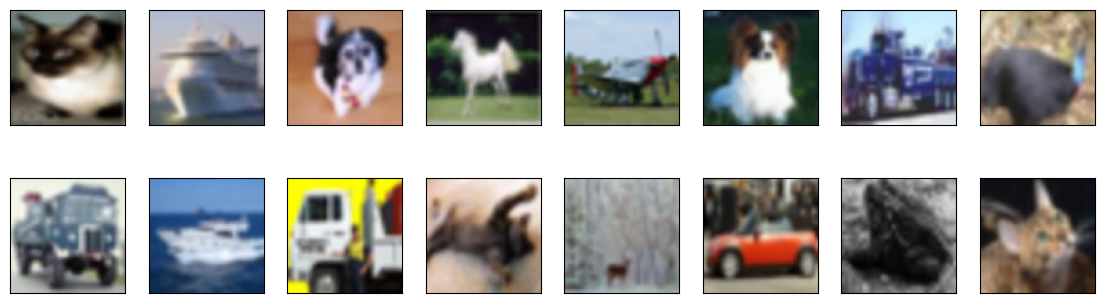

In [4]:
images, _ = next(iter(train_loader))
view_samples(images[:16])

In [5]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, use_batch_norm=True):
        super(ConvBlock, self).__init__()
        self.use_batch_norm = use_batch_norm

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride=2,
                              padding = 1, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.LeakyReLU(0.2)

    def forward(self, x):
        x = self.conv(x)
        x = self.batch_norm(x) if self.use_batch_norm else x
        return self.activation(x)


class Discriminator(nn.Module):
    def __init__(self, conv_dim=64, channels=3):  # Increased conv_dim
        super(Discriminator, self).__init__()
        self.discriminator = nn.Sequential(
            ConvBlock(channels, conv_dim, 4, use_batch_norm=False),
            ConvBlock(conv_dim, conv_dim * 2, 4),
            ConvBlock(conv_dim * 2, conv_dim * 4, 4),
            ConvBlock(conv_dim * 4, conv_dim * 8, 4),  # Extra layer

            nn.Flatten(),
            nn.Linear(conv_dim * 8 * 4 * 4, 1)  # Adjusted for 64x64 output
        )

    def forward(self, x):
        return self.discriminator(x)

In [6]:
class DeconvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride,
                 padding, use_batch_norm=True):
        super(DeconvBlock, self).__init__()
        self.use_batch_norm = use_batch_norm
        self.deconv = nn.ConvTranspose2d(in_channels, out_channels, kernel_size,
                                         stride, padding, bias=False)
        self.batch_norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.deconv(x)
        x = self.batch_norm(x) if self.use_batch_norm else x
        return self.activation(x)

class Generator(nn.Module):
    def __init__(self, latent_dim, conv_dim=64, channels=3):  # Increased conv_dim for higher res
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.generator = nn.Sequential(
            DeconvBlock(latent_dim, conv_dim * 8, 4, 1, 0),  # More layers for 64x64
            DeconvBlock(conv_dim * 8, conv_dim * 4, 4, 2, 1),
            DeconvBlock(conv_dim * 4, conv_dim * 2, 4, 2, 1),
            DeconvBlock(conv_dim * 2, conv_dim, 4, 2, 1),

            nn.ConvTranspose2d(conv_dim, channels, 4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        if x.dim() == 2:
            x = x.view(x.size(0), self.latent_dim, 1, 1)
        return self.generator(x)

In [7]:
conv_dim = 64  # Increased for higher resolution
latent_dim = 128  # Increase latent dimension for more expressive representations
channels = 3

discriminator = Discriminator(conv_dim, channels)
generator = Generator(latent_dim, conv_dim, channels)

gpu = torch.cuda.is_available()
if gpu:
    discriminator.cuda()
    generator.cuda()

In [8]:
lr = 0.0002
beta1 = 0.5
beta2 = 0.999
num_epochs = 50  # Increase from 10 to 50 for better convergence

disc_optimizer = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))
gen_optimizer = optim.Adam(generator.parameters(), lr=lr, betas=(beta1, beta2))

Epoch 1/50: 100%|██████████| 391/391 [01:06<00:00,  5.85it/s]


Epoch [1/50], D Loss: 0.3768, G Loss: 5.0202


Epoch 2/50: 100%|██████████| 391/391 [01:07<00:00,  5.76it/s]


Epoch [2/50], D Loss: 0.6847, G Loss: 3.4816


Epoch 3/50: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


Epoch [3/50], D Loss: 0.8505, G Loss: 2.6003


Epoch 4/50: 100%|██████████| 391/391 [01:07<00:00,  5.79it/s]


Epoch [4/50], D Loss: 0.4756, G Loss: 4.3492


Epoch 5/50: 100%|██████████| 391/391 [01:07<00:00,  5.77it/s]


Epoch [5/50], D Loss: 0.7961, G Loss: 2.3783


Epoch 6/50: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


Epoch [6/50], D Loss: 1.1219, G Loss: 1.2414


Epoch 7/50: 100%|██████████| 391/391 [01:07<00:00,  5.79it/s]


Epoch [7/50], D Loss: 0.4248, G Loss: 3.4650


Epoch 8/50: 100%|██████████| 391/391 [01:07<00:00,  5.78it/s]


Epoch [8/50], D Loss: 1.7848, G Loss: 2.6516


Epoch 9/50: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


Epoch [9/50], D Loss: 0.5129, G Loss: 4.2234


Epoch 10/50: 100%|██████████| 391/391 [01:07<00:00,  5.80it/s]


Epoch [10/50], D Loss: 0.4506, G Loss: 3.0337


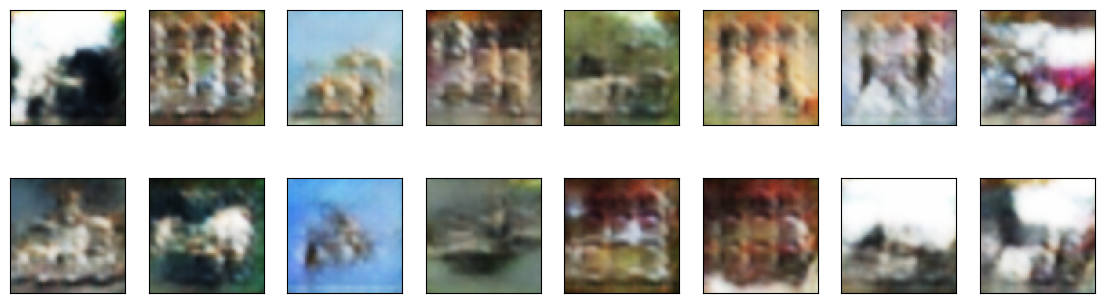

Epoch 11/50:  67%|██████▋   | 261/391 [00:45<00:22,  5.78it/s]


KeyboardInterrupt: 

In [9]:
for epoch in range(num_epochs):
    for real_images, _ in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_size = real_images.size(0)

        # Train the discriminator
        disc_loss = train_discriminator(real_images, discriminator, disc_optimizer,
                                        generator, latent_dim, gpu)

        # Train the generator
        gen_loss = train_generator(discriminator, generator, gen_optimizer, batch_size,
                                   latent_dim, gpu, channels=3)

    print(f"Epoch [{epoch+1}/{num_epochs}], "
          f"D Loss: {disc_loss:.4f}, G Loss: {gen_loss:.4f}")

    # Generate and view samples
    if (epoch + 1) % 10 == 0:  # Generate samples every 10 epochs to monitor progress
        samples = make_samples(generator, 16, latent_dim, channels=3, gpu=gpu)
        view_samples(samples)